# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:
- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método para aumentar a resolução (*shift-and-stitch*)


In [121]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Keras  1.2.0
Theano 0.8.2
OpenCV 3.1.0
Numpy  1.11.3


In [108]:
def show_scan(M, H, W):
    from IPython import display
    def printt(arr):
        for line in output.tolist():
            print ' '.join([' abcdefghijklmnop'[x] for x in line])

    M = 36
    image = np.zeros((1, 1, M, M))

    lab = 1
    output = np.zeros((M-H+1, M-W+1), np.uint8)
    for i in range(4):
        for j in range(4):
            oo = output[i::4, j::4]
            output[i::4, j::4] = lab * np.ones_like(oo)
            print 'origin: ({}, {}), shape: {}, label: {}'.format(i, j, oo.shape, ' abcdefghijklmnop'[lab])
            print
            printt(output)
            lab += 1
            time.sleep(2)
            display.clear_output(wait=True)

def make_image(X_test, y_test, M=200, H=28, W=28):
    M = 200
    char_index = np.random.choice(X_test.shape[0], 4, replace=False)
    char_img = [img.reshape(H,W) for img in (255*X_test).astype(np.uint8)[char_index]]
    char_lab = [y for y in y_test_[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(0, 0), (50, 150), (100, 100), (171, 171)]
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

### MNIST dataset

In [83]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)
H = W = 28

(X_train, y_train_), (X_test, y_test_) = mnist.load_data()

X_train = X_train.reshape(-1, 1, H, W) / 255.0
X_test = X_test.reshape(-1, 1, H, W) / 255.0

y_train = np_utils.to_categorical(y_train_, 10)
y_test = np_utils.to_categorical(y_test_, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Carregando nosso modelo pre-treinado

In [84]:
print("[INFO] loading model...")
model_name = '../../models/keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)

print("[INFO] evaluating...")
loss, accuracy = model_A.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

model_A.summary()

[INFO] loading model...
[INFO] evaluating...
10000/10000 [==============================] - 4s     

## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 500. Seus pesos têm portanto dimensão 2450x500.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 500x1x1, a convolução deve criar 500 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


<table align='left'>
<tr><td colspan=2> <img src="../figures/fully_conv_5.png" alt="Drawing" style="width: 700px;"/> </td></tr>
</table>


In [100]:
W_all_A = model_A.get_weights()
print [w.shape for w in W_all_A]

[(20, 1, 5, 5), (20,), (50, 20, 5, 5), (50,), (2450, 500), (500,), (500, 10), (10,)]


In [85]:
model_name = './keras_lenet_fullconv'

class BaseNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

class FullConvNet:
    @staticmethod
    def build():
        model = Sequential()
        
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                batch_input_shape=(128, 1, None, None)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(500, 7, 7, border_mode="valid"))        
        model.add(Activation("relu"))

        model.add(Convolution2D(10, 1, 1, border_mode="valid"))        

        return model

model_B = FullConvNet.build()
model_B.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (128, 20, None, None) 520         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_4 (Activation)        (128, 20, None, None) 0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (128, 20, None, None) 0           activation_4[0][0]               
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (128, 50, None, None) 25050       maxpooling2d_3[0][0]             
___________________________________________________________________________________________

## Ajustando os pesos do modelo todo convolucional

<table align='left'>
<tr><td colspan=2> <img src="../figures/fully_conv_6.png" alt="Drawing" style="width: 700px;"/> </td></tr>
</table>


In [101]:
W_all_B = model_B.get_weights()

print [w.shape for w in W_all_A]
print [w.shape for w in W_all_B]

W_all_B = [
    W_all_A[0],
    W_all_A[1],
    W_all_A[2],
    W_all_A[3],
    W_all_A[4].T.reshape(500, 50, 7, 7)[:, :, ::-1, ::-1],
    W_all_A[5],
    W_all_A[6].T.reshape(10, 500, 1, 1)[:, :, ::-1, ::-1],
    W_all_A[7],
]
model_B.set_weights(W_all_B)

model_B.compile(optimizer='sgd', loss="categorical_crossentropy")


[(20, 1, 5, 5), (20,), (50, 20, 5, 5), (50,), (2450, 500), (500,), (500, 10), (10,)]
[(20, 1, 5, 5), (20,), (50, 20, 5, 5), (50,), (500, 50, 7, 7), (500,), (10, 500, 1, 1), (10,)]


## Verificando a performance

In [87]:
def softmax(Z, axis=-1):
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=axis,keepdims=True)
    return S

pp = model_B.predict(X_test)
pp = softmax(pp, 1)

In [88]:
smo = np.argmax(pp, axis=1).reshape(-1)
print 100.0 * np.where(smo == y_test_, 1, 0).sum() / y_test_.shape[0]

99.34


## Janela deslizante

Agora que temos uma rede toda convolucional, vejamos o que acontece se a imagem de entrada é maior que as imagens utilizadas para treinamento (28x28).

A figura abaixo, ilustra o processo mostrando as dimensões dos *features* através de uma linha da imagem de entrada com dimensões 36x36. Acompanhemos cada passo:

- imagem de entrada (representada na figura em uma dimensão apenas): 1x36x36;
- convolução 20 filtros 5x5, borda *'same'*: 20x36x36
- maxpool 2x2, stride 2x2: 20x18x18
- convolução 50 filtros 5x5, borda *'same'*: 50x18x18
- maxpool 2x2, stride 2x2: 50x9x9
- convolução 500 filtros 7x7, borda *'valid'*: 500x3x3
- convolução 10 filtros 1x1: 10x3x3

<table align='left'>
<!-- <tr><td> <img src="../figures/fully_conv_4.png" alt="Drawing" style="width: 200px;"/> </td> <td/></tr> -->
<tr><td colspan=2> <img src="../figures/fully_conv_3.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

In [116]:
M = 200
image, coords, xlabel = make_image(X_test, y_test, M, H, W)

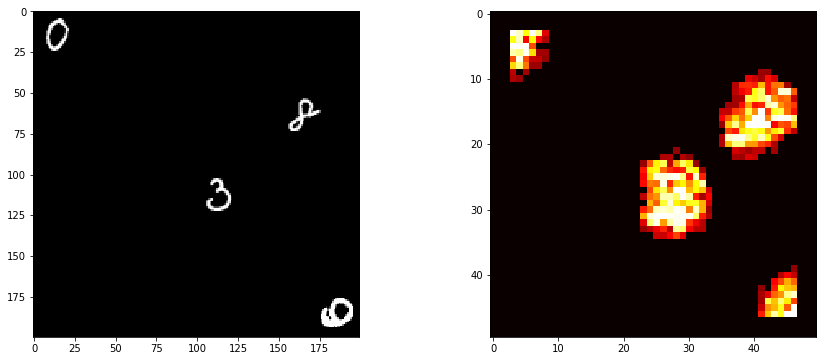

In [117]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(image, cmap=plot.cm.gray)

in_image = image.astype(np.float32).reshape(1, 1, M, M) / 255.0

pp = model_B.predict(in_image)[0]
pp = softmax(pp, 0)

pmax = pp.max(0)
pmax = np.where(pmax < 0.2, 0, pmax)

hm = np.zeros((50,50), pmax.dtype)
hm[3:-3, 3:-3] = pmax

fig.add_subplot(1,2,2)
plot.imshow(255 * hm, cmap=plot.cm.hot);


**Atenção:** Observe que as duas imagens acima possuem resolução (*shape*) diferentes. A resolução da imagem de entrada, mostrada à esquerda, é de (200,200) e a resolução da imagem de saída (à direita) é de (50,50).

## Aumentando a resolução



In [118]:
show_scan(M, H, W)

origin: (3, 3), shape: (2, 2), label: p

a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a


0 0 (10, 44, 44)
0 1 (10, 44, 43)
0 2 (10, 44, 43)
0 3 (10, 44, 43)
1 0 (10, 43, 44)
1 1 (10, 43, 43)
1 2 (10, 43, 43)
1 3 (10, 43, 43)
2 0 (10, 43, 44)
2 1 (10, 43, 43)
2 2 (10, 43, 43)
2 3 (10, 43, 43)
3 0 (10, 43, 44)
3 1 (10, 43, 43)
3 2 (10, 43, 43)
3 3 (10, 43, 43)
0.0 1.0
(10, 173, 173) (173, 173) 1.0 0 0.999919 0


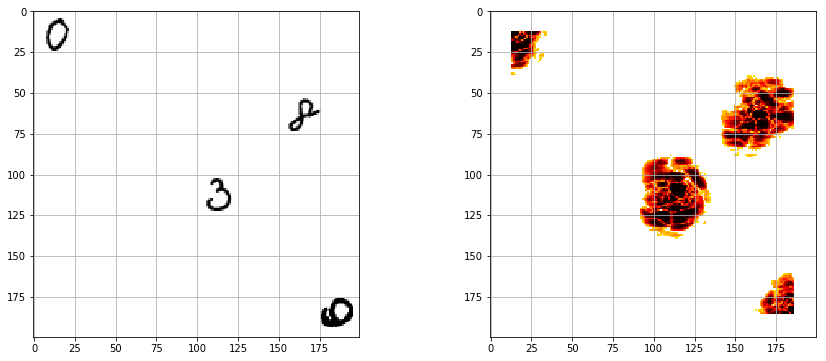

In [119]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(255 - image, cmap=plot.cm.gray)
plot.grid(True)

output = np.zeros((10, M-H+1, M-W+1), np.float32)
for i in range(4):
    for j in range(4):
        output[:, i::4, j::4] = oo = model_B.predict(in_image[:, :, i:, j:])[0]
        print i, j, oo.shape

output = softmax(output, 0)
pmax = output.max(0)
imax = output.argmax(0)
pmax = np.where(pmax < 0.3, 0, pmax)
print pmax.min(), pmax.max()
print output.shape, pmax.shape, pmax[0,0], imax[0,0], pmax[-1,-1], imax[-1,-1]

phm = np.zeros((M,M), pmax.dtype)
phm[(H+1)/2-1:-H/2, (W+1)/2-1:-W/2] = pmax

ihm = np.zeros((M,M), imax.dtype)
ihm[(H+1)/2-1:-H/2, (W+1)/2-1:-W/2] = imax

fig.add_subplot(1,2,2)
plot.imshow(255 * (1.0 - phm), cmap=plot.cm.hot)
# plot.imsave('heatmap.png', 255 * pmax)
plot.grid(True)

In [120]:
for k, (i, j) in zip(xlabel, coords):
    for m in (-1, 0, 1):
        for n in (-1, 0, 1):
            print 'p = {:.5f}, char: \'{}\' [correct: \'{}\']'.format(phm[i+m+13, j+n+13], 
                                                                      ihm[i+m+13, j+n+13], k),
            if m == n == 0:
                print '**'
            else:
                print
    print
        

p = 0.00000, char: '0' [correct: '0']
p = 0.00000, char: '0' [correct: '0']
p = 0.00000, char: '0' [correct: '0']
p = 0.00000, char: '0' [correct: '0']
p = 1.00000, char: '0' [correct: '0'] **
p = 1.00000, char: '0' [correct: '0']
p = 0.00000, char: '0' [correct: '0']
p = 1.00000, char: '0' [correct: '0']
p = 1.00000, char: '0' [correct: '0']

p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8'] **
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']
p = 1.00000, char: '8' [correct: '8']

p = 0.99875, char: '3' [correct: '3']
p = 0.99990, char: '3' [correct: '3']
p = 0.99991, char: '3' [correct: '3']
p = 0.80858, char: '0' [correct: '3']
p = 0.84278, char: '3' [correct: '3'] **
p = 0.98525, char: '3' [correct: '3']
p = 0.96684, char: '0' [correct: '3']
p = 0.87856, char: '0' [correct: '3']
p

## Observações

- A rede base utilizada não foi treinada para a não-ocorrência de um dos dez caracteres, nem de recortes parciais dos caracteres originais.
- Um exercício interessante seria treinar o modelo com os caracteres sobrepostos a imagens de fundo, além de recortes do fundo sem caracter (11 classes).


## Aprendizados com este notebook
